# Latent features

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from warofwords import Dataset
from warofwords import TrainedWarOfWordsLatent

from warofwords.plotting import sigconf_settings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

LEG = 8
FEAT = 'all_features-latent-text'
BASE = '/Users/kristof/GitHub/parl/public/war-of-words-2/'

## Load data

In [2]:
dossier2title = dict()
with open(f'{BASE}/data/helpers/dossier-titles.json', 'r') as f:
    dossier2title = json.load(f)

In [3]:
model_path = f'{BASE}/2-training/trained-models/ep{LEG}-{FEAT}.fit'
model = TrainedWarOfWordsLatent.load(model_path)
vec = model._vec
parameters = model.parameters
features = parameters._features

In [4]:
meps = parameters._features.get_group('mep')
doss = parameters._features.get_group('dossier')

## PCA

In [5]:
def get_dossiers(features, vec):
    """Get top (which='top') or bottom (which='bottom') dossiers."""
    doss = features.get_group('dossier')
    return [features.get_name(d) for d in doss], vec[doss]

In [6]:
doss_refs, vec_y = get_dossiers(features, vec)

In [7]:
n_dims = 20
pca = PCA(n_components=n_dims)
pca.fit(vec_y)

PCA(n_components=20)

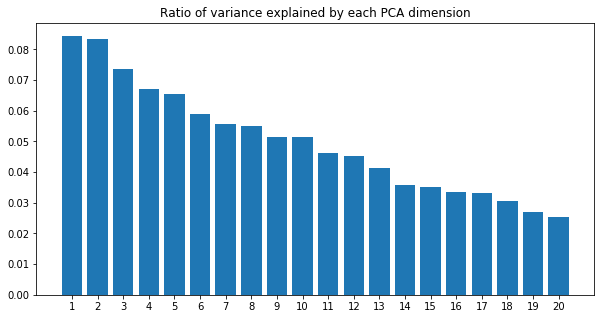

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(n_dims) + 1
ax.bar(x, pca.explained_variance_ratio_)
ax.set_title("Ratio of variance explained by each PCA dimension")
ax.set_xticks(x)
plt.show()

In [9]:
def plot_pca(pca, vec_y, doss_refs, dim, which, n=10):
    """Order: which='top' or which='bottom'"""
    coords = pca.transform(vec_y)
    # Sorted according to coordinate along one PCA dimension.
    idx = np.argsort(coords[:, dim])
    # Get order.
    if which == 'top':
         rank = idx[::-1][:n]
    elif which == 'bottom':
         rank = idx[:n][::-1]
    # Plot top-n.
    for i in rank:
        ref = doss_refs[i]
        title = dossier2title[ref]
        print(f'{coords[i, dim]:+.3f} {ref:<10} {title}\n')

In [10]:
plot_pca(pca, vec_y, doss_refs, dim=0, which='top')

+2.074 A8-0318-2017 European Electronic Communications Code (Recast)

+1.395 A8-0238-2016 Prospectus to be published when securities are offered to the public or admitted to trading

+1.110 A8-0305-2017 Body of European Regulators for Electronic Communications

+1.074 A8-0438-2018 Re-use of public sector information (recast)

+0.965 A8-0056-2017 Prevention of the use of the financial system for the purposes of money laundering or terrorist financing

+0.910 A8-0008-2017 Establishing a Union programme to support specific activities enhancing the involvement of consumers and other financial services end-users in Union policy making in the field of financial services for the period of 2017-2020

+0.851 A8-0211-2017 Financial rules applicable to the general budget of the Union

+0.847 A8-0409-2018 Establishing the Connecting Europe Facility

+0.827 A8-0011-2019 European Union macro-prudential oversight of the financial system and establishing a European Systemic Risk Board

+0.761 A8-0483-

In [11]:
plot_pca(pca, vec_y, doss_refs, dim=0, which='bottom')

-0.613 IMCO-AD(2015)546844 Single-member private limited liability companies

-0.648 A8-0270-2015 Reduction of pollutant emissions from road vehicles

-0.669 JURI-AD(2017)597525 Addressing geo-blocking and other forms of discrimination based on customers' nationality, place of residence or place of establishment within the internal market

-0.689 ENVI-AD(2017)609648 Internal market for electricity (recast)

-0.691 A8-0011-2016 Activities and supervision of institutions for occupational retirement provision (recast)

-0.714 A8-0327-2016 Use of the 470-790 MHz frequency band in the Union

-0.763 BUDG-AD(2018)612357 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-0.869 A8-0139-2015 European Fund for Strategic Investments

-1.135 A8-0482-2018 Establishing the InvestEU Programme

-1.473 A8-0199-2015 Protection of undisclosed know-how and business information (trade secrets) again

In [12]:
plot_pca(pca, vec_y, doss_refs, dim=1, which='top')

+1.826 A8-0278-2018 Pan-European Personal Pension Product (PEPP)

+1.700 A8-0011-2016 Activities and supervision of institutions for occupational retirement provision (recast)

+0.826 A8-0317-2018 Reduction of the impact of certain plastic products on the environment

+0.820 BUDG-AD(2018)612357 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

+0.730 TRAN-AD(2018)623885 Establishing a European Labour Authority

+0.671 AFET-AD(2018)616888 Establishing a framework for screening of foreign direct investments into the European Union

+0.653 A8-0321-2018 Promotion of clean and energy-efficient road transport vehicles

+0.632 AFET-AD(2015)549344 Use of Passenger Name Record data (EU PNR)

+0.605 CONT-AD(2018)627881 European Social Fund Plus (ESF+)

+0.589 REGI-AD(2018)626678 Establishing the Connecting Europe Facility



In [13]:
plot_pca(pca, vec_y, doss_refs, dim=1, which='bottom')

-0.754 CULT-AD(2017)595592 Rules on the exercise of copyright and related rights applicable to certain online transmissions of broadcasting organisations and retransmissions of television and radio programmes

-0.787 A8-0396-2017 Enforcement of the Directive 2006/123/EC on services in the internal market, laying down a notification procedure for authorisation schemes and requirements related to services, and amending Directive 2006/123/EC and Regulation (EU) No 1024/2012 on administrative cooperation through the Internal Market Information System

-0.810 ENVI-AD(2018)627836 European Social Fund Plus (ESF+)

-0.830 A8-0198-2017 Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub

-0.837 A8-0021-2018 Definition, presentation and labelling of spirit drinks, the use of the names of spirit drinks in the presentation and labelling of other foodstuffs and the prote

## t-SNE

In [14]:
def plot_tsne(pca, vec_y, perplexity, seed=0, n=10):
    coords = pca.transform(vec_y)
    dims = [0, 1]
    # Get dossiers (avoid double counting).
    idx = set()
    for dim in dims:
        idx.update(np.argsort(coords[:,dim])[::-1][:n])
        idx.update(np.argsort(coords[:,dim])[:n])
    idx = np.array(list(idx))
    print(f'Keeping {len(idx)} dossiers for projection')
    
    # Compute t-SNE
    tsne = TSNE(perplexity=perplexity, random_state=seed)
    embed = tsne.fit_transform(vec_y[idx,:])
    plt.scatter(embed[:, 0],embed[:,1])
    plt.show()
    
    return embed, coords, idx


def display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi):
    for i, (x, y) in zip(idx, embed):
        cond_x = (x < x_hi) and (x > x_lo)
        cond_y = (y < y_hi) and (y > y_lo)
        if cond_x and cond_y:
            ref = doss_refs[i]
            title = dossier2title[ref]
            print(f'{x:+.0f} {y:+.0f} {ref:<10} {title}\n')

Seed: 21
Perplexity: 3
Keeping 36 dossiers for projection


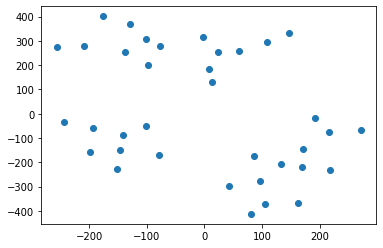

In [15]:
seed = 21
perplexity = 3
print(f'Seed: {seed}')
print(f'Perplexity: {perplexity}')
embed, coords, idx = plot_tsne(pca, vec_y, perplexity=perplexity, seed=seed, n=10)

In [16]:
# Top-left.
x_lo, x_hi = -400, -50
y_lo, y_hi = 150, 500
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

-102 +307 CONT-AD(2018)627881 European Social Fund Plus (ESF+)

-256 +275 A8-0238-2016 Prospectus to be published when securities are offered to the public or admitted to trading

-98 +202 A8-0278-2018 Pan-European Personal Pension Product (PEPP)

-208 +277 A8-0008-2017 Establishing a Union programme to support specific activities enhancing the involvement of consumers and other financial services end-users in Union policy making in the field of financial services for the period of 2017-2020

-177 +402 A8-0305-2017 Body of European Regulators for Electronic Communications

-137 +254 A8-0317-2018 Reduction of the impact of certain plastic products on the environment

-77 +277 A8-0321-2018 Promotion of clean and energy-efficient road transport vehicles

-130 +369 A8-0011-2019 European Union macro-prudential oversight of the financial system and establishing a European Systemic Risk Board



In [17]:
# Top-right.
x_lo, x_hi = -10, 200
y_lo, y_hi = 0, 400
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

+109 +297 BUDG-AD(2018)612357 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

-2 +318 TRAN-AD(2018)623885 Establishing a European Labour Authority

+60 +258 AFET-AD(2018)616888 Establishing a framework for screening of foreign direct investments into the European Union

+23 +255 REGI-AD(2018)626678 Establishing the Connecting Europe Facility

+14 +131 A8-0211-2017 Financial rules applicable to the general budget of the Union

+147 +334 A8-0011-2016 Activities and supervision of institutions for occupational retirement provision (recast)

+8 +184 AFET-AD(2015)549344 Use of Passenger Name Record data (EU PNR)



In [18]:
# Bottom-right.
x_lo, x_hi = 0, 400
y_lo, y_hi = -500, 0
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

+105 -374 A8-0412-2018 Establishing the European Defence Fund

+172 -147 A8-0396-2017 Enforcement of the Directive 2006/123/EC on services in the internal market, laying down a notification procedure for authorisation schemes and requirements related to services, and amending Directive 2006/123/EC and Regulation (EU) No 1024/2012 on administrative cooperation through the Internal Market Information System

+217 -232 A8-0483-2018 Low carbon benchmarks and positive carbon impact benchmarks

+169 -220 ENVI-AD(2018)630616 Low carbon benchmarks and positive carbon impact benchmarks

+163 -370 A8-0037-2018 Establishing the European Defence Industrial Development Programme aiming at supporting the competitiveness and innovative capacity of the EU defence industry

+216 -76 A8-0056-2017 Prevention of the use of the financial system for the purposes of money laundering or terrorist financing

+86 -172 CULT-AD(2017)595592 Rules on the exercise of copyright and related rights applicable to certai

In [19]:
# Bottom-left.
x_lo, x_hi = -400, 0
y_lo, y_hi = -300, 0
display_dossiers(embed, coords, idx, doss_refs, x_lo, x_hi, y_lo, y_hi)

-243 -36 A8-0199-2015 Protection of undisclosed know-how and business information (trade secrets) against their unlawful acquisition, use and disclosure

-146 -148 JURI-AD(2017)597525 Addressing geo-blocking and other forms of discrimination based on customers' nationality, place of residence or place of establishment within the internal market

-194 -59 A8-0327-2016 Use of the 470-790 MHz frequency band in the Union

-199 -157 A8-0270-2015 Reduction of pollutant emissions from road vehicles

-101 -52 ENVI-AD(2017)609648 Internal market for electricity (recast)

-79 -169 A8-0198-2017 Extension of the duration of the European Fund for Strategic Investments as well as the introduction of technical enhancements for that Fund and the European Investment Advisory Hub

-151 -228 A8-0482-2018 Establishing the InvestEU Programme

-142 -87 IMCO-AD(2015)546844 Single-member private limited liability companies



In [25]:
clusters = {
   # Social Security and Environment
    'ss': 0,  
   # Investment and Development
    'id': 1,  
   # Defense and Protection
    'dp': 2,  
   # Economic Competitiveness
    'ec': 3,  
   # Others
    'ot': 4,  
}

ref2cluster = {
    # Top-left: Social and Environmental Security
    'CONT-AD(2018)627881': 'ss', # European Social Fund Plus
    'A8-0238-2016': 'ot', # Prospectus offered when securities offered to the public for trading
    'A8-0278-2018': 'ss', # Pan-European Personal Pension Product
    'A8-0008-2017': 'ss', # Involvement of consumers and end-users in financial services
    'A8-0305-2017': 'ss', # Electronic Communications
    'A8-0317-2018': 'ss', # Reduction of the impact of certain plastic products on the environment
    'A8-0321-2018': 'ss', # Promotion of clean and energy-efficient road transport vehicles
    'A8-0011-2019': 'ss', # European Union macro-prudential oversight of the financial system
     # Top-right cluster: Investment and Development
    'BUDG-AD(2018)612357': 'id', # European Defence Industrial Development Programme for competitiveness of industry
    'TRAN-AD(2018)623885': 'id', # European Labour Authority
    'AFET-AD(2018)616888': 'id', # Establishing a framework for screening of foreign direct investments
    'REGI-AD(2018)626678': 'id', # Connecting Europe Facility
    'A8-0211-2017': 'id', # Financial rules applicable to the general budget of the Union
    'A8-0011-2016': 'id', # Activities and supervision of institutions for occupational retirement provision
    'AFET-AD(2015)549344': 'id', # Use of Passenger Name Record data
    # Bottom-right cluster: Defense and Protection
    'A8-0412-2018': 'dp', # European Defense Fund
    'A8-0396-2017': 'dp', # Exchange of information between public authorities involved in the practical implementation of EU law
    'A8-0483-2018': 'ot', # Low carbon benchmarks and positive carbon impact benchmarks
    'ENVI-AD(2018)630616': 'ot', # Low carbon benchmarks and positive carbon impact benchmarks
    'A8-0037-2018': 'dp', # European Defence Industrial Development Programme
    'A8-0056-2017': 'dp', # Prevention of the use of the financial system for the purposes of money laundering or terrorist financing
    'CULT-AD(2017)595592': 'dp', # Copyrights to certain online transmissions of broadcasting organisations
    'A8-0318-2017': 'dp', # European Electronic Communications Code
    'A8-0438-2018': 'dp', # Re-use of public sector information
    'A8-0139-2015': 'dp', # European Fund for Strategic Investments
    'A8-0021-2018': 'dp', # Definition, presentation and labelling of spirit drinks
    'ENVI-AD(2018)627836': 'dp', # European Social Fund Plus (ESF+)
    'A8-0409-2018': 'dp', # Establishing the Connecting Europe Facility
    # Left cluster: Economic Competitiveness
    'A8-0199-2015': 'ec', # Protection of trade secrets
    'JURI-AD(2017)597525': 'ec', # Addressing geo-blocking and other forms of discrimination based on customers' nationality
    'A8-0327-2016': 'ec', # Use of the 470-790 MHz frequency band
    'A8-0270-2015': 'ec', # Reduction of pollutant emissions from road vehicles
    'ENVI-AD(2017)609648': 'ec', # Internal market for electricity
    'A8-0198-2017': 'ec', # Extension of the duration of the European Fund for Strategic Investments
    'A8-0482-2018': 'ec', # Establishing the InvestEU Programme
    'IMCO-AD(2015)546844': 'ec', # Facilitate establishment of single-shareholders companies
}    


colors = {
    'dp': 'C3',
    'ec': 'C1',
    'ss': 'C2',
    'id': 'C0',
    'ot': 'lightgray',
}

markers = {
    'dp': 'X',
    'ec': 's',
    'ss': 'v',
    'id': 'o',
    'ot': '.',
}

labels = [
    r'SS\&E',
    r'I\&D',
    r'D\&P',
    r'EC',
    r'Others',
#     r'Defense \& Protection',
#     r'Investment \& Development',
#     r'Social Security',
#     r'Economic Competitiveness',
#     r'Others'
]

## Plot for paper

Sigconf settings loaded!


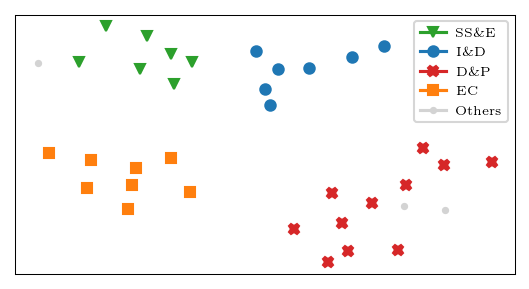

In [26]:
sigconf_settings()
fig, ax = plt.subplots(figsize=(3.6, 2.0))

lines = dict()

for i, (x, y) in zip(idx, embed):
    ref = doss_refs[i]
    cluster = ref2cluster[ref]
    line = ax.plot(x, y, color=colors[cluster], marker=markers[cluster], markersize=5)
    if cluster not in line:
        lines[cluster] = line[0]
    
handles = [lines['ss'],
           lines['id'],
           lines['dp'],
           lines['ec'],
           lines['ot']]



legend = plt.legend(handles, labels,
           loc='best',
           frameon=True,
           fontsize='x-small',
#            labelspacing=.2,
#            bbox_to_anchor=(0.52,0.78)
          )
# Change the marker size manually for both lines.
# for handle in legend.legendHandles:
#     handle._legmarker.set_markersize(4)

plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,        # tickcs on the left edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off
# plt.title('t-SNE visualization of latent feature y_i')
plt.tight_layout()
plt.savefig('figures/tsne.pdf', bbox_inches='tight')
plt.show()

### Generate t-SNE plots for visual inspection

In [ ]:
ps = [2.5]
# 3: 21, 22, 76
# 2.5: 21, 41
ss = list(range(0, 100))
for p, s in product(ps, ss):
    print(f'Seed: {s} - Perplexity: {p}')
    embed, coords, _ = plot_tsne(pca, vec_y, perplexity=p, seed=s, n=10)